# **CA 2, LLMs Spring 2025**

- **Name:OMID**
- **Student ID:!**

---
#### Your submission should be named using the following format: `CA2_LASTNAME_STUDENTID.ipynb`.

---

##### *How to do this problem set:*

- Some questions require writing Python code and computing results, and the rest of them have written answers. For coding problems, you will have to fill out all code blocks that say `YOUR CODE HERE`.

- For text-based answers, you should replace the text that says ```Your Answer Here``` with your actual answer.

- There is no penalty for using AI assistance on this homework as long as you fully disclose it in the final cell of this notebook (this includes storing any prompts that you feed to large language models). That said, anyone caught using AI assistance without proper disclosure will receive a zero on the assignment (we have several automatic tools to detect such cases). We're literally allowing you to use it with no limitations, so there is no reason to lie!

---

##### *Academic honesty*

- We will audit the Colab notebooks from a set number of students, chosen at random. The audits will check that the code you wrote actually generates the answers in your notebook. If you turn in correct answers on your notebook without code that actually generates those answers, we will consider this a serious case of cheating.

- We will also run automatic checks of Colab notebooks for plagiarism. Copying code from others is also considered a serious case of cheating.

---

If you have any further questions or concerns, contact the TAs via email: m.salmani78@ut.ac.ir / mehrabi.m@ut.ac.ir

## Preliminaries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q bitsandbytes

In [3]:
!pip install -q datasets Levenshtein
!pip install -q trl

In [4]:
import torch
import numpy as np
import re
import time
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from Levenshtein import ratio
from collections import defaultdict
from datasets import load_dataset
from trl import ORPOConfig, ORPOTrainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [6]:
class CONFIG:
    seed = 42
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model_name = "unsloth/Llama-3.2-3B-Instruct-bnb-4bit"
    reward_model_name = "nicolinho/QRM-Llama3.1-8B-v2"
    benchmark_name = "openai/gsm8k"
    dataset_name = "mlabonne/orpo-dpo-mix-40k"

    train_data_size = 1600
    benchmark_subset_size = 50
    max_seq_length = 1024
    train_batch_size = 2
    gradient_accumulation_steps = 4
    epochs = 1

    # LoRA Configs
    lora_rank = 64
    lora_alpha = 64
    use_gradient_checkpointing = "unsloth"
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],

    dpo_output_dir = "/content/drive/MyDrive/Colab Notebooks/CA2/llama-3.2-3b-dpo-checkpoint"
    orpo_output_dir = "/content/drive/MyDrive/Colab Notebooks/CA2/llama-3.2-3b-orpo-checkpoint"

device = CONFIG.device

### Introductions to unsloth

Modern large language models (LLMs) require significant computational resources for fine-tuning and inference. The `unsloth` library is designed to optimize these processes by making training up to 30× faster and reducing memory usage by 60%, enabling more efficient model adaptation on consumer-grade GPUs.

---

**Learn More:**

<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

### Install and Setup

In [7]:
%%capture
import os
!pip install datasets
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
    !pip install --no-deps cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [8]:
import unsloth
print(unsloth.__version__)

<ipython-input-8-e98318b663f4>:1: UserWarning: WARNING: Unsloth should be imported before trl, transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  import unsloth


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


    PyTorch 2.5.1+cu121 with CUDA 1201 (you have 2.6.0+cu124)
    Python  3.11.11 (you have 3.11.12)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


🦥 Unsloth Zoo will now patch everything to make training faster!
2025.5.6


# In-context Learning (30 Points)

### Question 1 (5 points):

**a)** What is In-Context Learning (ICL), and how does it differ from fine-tuning? What are its limitations compared to fine-tuning?

**b)** Explain what [Chain-of-Thought (CoT)](https://arxiv.org/abs/2201.11903) prompting is and how it works.

a) In-Context Learning (ICL) is a method where large language models learn to perform tasks by seeing examples in the input prompt, without any change to the model’s parameters. It differs from fine-tuning in that fine-tuning involves updating the model's internal weights using a labeled dataset to permanently improve performance on specific tasks. ICL is faster and requires fewer resources because it avoids retraining, but it has limitations: it relies on temporary memory (only during inference), is constrained by the maximum input length (token limit), and is generally less accurate or robust for complex or specialized tasks compared to fine-tuned models. Fine-tuning allows for deeper, lasting adaptation, while ICL is more like “on-the-fly” learning.

b) Chain-of-Thought (CoT) prompting is a technique used to improve the reasoning abilities of language models by encouraging them to generate intermediate steps when solving a problem. Instead of asking the model to directly produce an answer, CoT prompting provides examples where problems are solved step-by-step, guiding the model to mimic that reasoning pattern. This approach helps especially in multi-step problems like math, logic, or commonsense reasoning, as it allows the model to “think out loud” before reaching the final answer. CoT is particularly effective in large models and often leads to more accurate and explainable responses.

### Load Model & Tokenizer (2.5 points)

- Load `Llama-3.2-3B-Instruct-bnb-4bit` model using `unsloth` for inference.

In [9]:
from unsloth import FastLanguageModel

def load_model_and_tokenizer(model_id, max_seq_length):
    print("Loading model and tokenizer using unsloth...")
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = model_id,
        max_seq_length = max_seq_length,
        dtype = None,
        load_in_4bit = True,
    )
    return model, tokenizer

In [ ]:
model, tokenizer = load_model_and_tokenizer(CONFIG.model_name, CONFIG.max_seq_length)

### Load benchmark (2.5 points)

1. Load the `GSM8K` benchmark dataset.
2. Randomly select a subset of `50` samples from the dataset.
3. Display one sample from the selected subset.
<a id="gsm8k_benchmark"></a>

In [ ]:
import random

def load_gsm8k_dataset():
    """Load the GSM8K dataset from HuggingFace."""
    dataset = load_dataset("gsm8k", "main")
    return dataset

def create_sample_dataset(dataset, num_samples, seed):
    """Create a fixed sample dataset for evaluation."""
    sample_test = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    return sample_test

In [ ]:
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
dataset = load_gsm8k_dataset()

# Select subset
sample_dataset = create_sample_dataset(dataset, num_samples=CONFIG.benchmark_subset_size, seed=CONFIG.seed)


README.md:   0%|          | 0.00/7.94k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [ ]:
# Display one sample
print(sample_dataset[0])

{'question': 'Mimi picked up 2 dozen seashells on the beach.  Kyle found twice as many shells as Mimi and put them in his pocket. Leigh grabbed one-third of the shells that Kyle found.  How many seashells did Leigh have?', 'answer': 'Mimi has 2 x 12 = <<2*12=24>>24 sea shells.\nKyle has 24 x 2 = <<24*2=48>>48 sea shells.\nLeigh has 48 / 3 = <<48/3=16>>16 sea shells.\n#### 16'}


### Prompt Engineering (10 points)

Implement different prompting strategies for in-context learning.
At least four of the following methods should be implemented (including baseline):
- Zero-shot (**Baseline**)
- Role-play prompting [[paper](https://aclanthology.org/2024.naacl-long.228/)]
- Zero-shot CoT [[paper](https://arxiv.org/abs/2205.11916)]
- Few-shot CoT
- Least-to-Most prompting [[paper](https://arxiv.org/abs/2205.10625)]
- Generated Knowledge prompting [[paper](https://aclanthology.org/2022.acl-long.225/)]
- Any other idea to improve performance (**Optional**)

Additionally, if performance exceeds 80%, **two extra points** are awarded for every 5% improvement. You can try other methods or a combination of existing ones.

<a id="prompt-engineering"></a>

In [ ]:
def create_prompts(question, examples=None):
    """
    Build multiple chat-style prompts aligned with medium-to-advanced multi-step word problems.
    Answer format is simplified as: [ANSWER]: <final number>
    """
    prompts = {}
    final_format_instruction = "Return only the final numeric answer using this format:\n[ANSWER]: <your final answer>"

    DEFAULT_FEW_SHOT_EXAMPLES = [
        {
            "question": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",
            "answer": "Natalia sold 48 clips in April. In May, she sold half as many clips as in April, so she sold 48 / 2 = 24 clips. Altogether, Natalia sold 48 + 24 = 72 clips.\n[ANSWER]: 72"
        },
        {
            "question": "Weng earns $12 an hour for babysitting. Yesterday, she just did 50 minutes of babysitting. How much did she earn?",
            "answer": "Weng earns $12 an hour, which is $12 / 60 minutes = $0.20 per minute. Since she babysat for 50 minutes, she earned 50 * $0.20 = $10.\n[ANSWER]: 10"
        },
        {
            "question": "Betty is saving money for a new wallet which costs $100. Betty has only half of the money she needs. Her parents decided to give her $15 for that purpose, and her grandparents twice as much as her parents. How much more money does Betty need to buy the wallet?",
            "answer": "The wallet costs $100. Betty has half the money, so she has $100 / 2 = $50. Her parents give her $15. Her grandparents give her twice as much as her parents, so they give her 2 * $15 = $30. In total, Betty has $50 + $15 + $30 = $95. She needs $100 to buy the wallet, so she needs $100 - $95 = $5 more.\n[ANSWER]: 5"
        }
    ]

    if examples is None:
        examples = DEFAULT_FEW_SHOT_EXAMPLES

    # Baseline
    prompts["Baseline"] = [
        {"role": "system", "content": "You are a math assistant that only provides final numeric answers."},
        {"role": "user", "content": (
            f"Problem: {question}\n\n"
            f"Please output only the final numeric result in the following format:\n[ANSWER]: <your final answer>"
        )}
    ]

    # Role-Prompting
    prompts["Role-Prompting"] = [
        {"role": "system", "content": "You are a brilliant mathematician who solves problems step-by-step with clear logic."},
        {"role": "user", "content": (
            f"Problem: {question}\n"
            "Think through the steps carefully. Then return only the final numeric answer.\n"
            f"{final_format_instruction}"
        )}
    ]

    # Zero-shot CoT
    prompts["Zero-shot CoT"] = [
        {"role": "system", "content": "You are a math tutor who solves problems step-by-step."},
        {"role": "user", "content": (
            f"Problem: {question}\nLet's think step-by-step.\n\n{final_format_instruction}"
        )}
    ]

    # Few-shot CoT
    few_shot_cot_prompt = [{"role": "system", "content": "You are a helpful math tutor. Think step-by-step and return only the final number in the format: [ANSWER]: <your final answer>"}]

    for ex in examples:
        few_shot_cot_prompt.append({"role": "user", "content": f"Problem: {ex['question']}\nLet's think step-by-step."})
        few_shot_cot_prompt.append({"role": "assistant", "content": ex['answer']})

    few_shot_cot_prompt.append({"role": "user", "content": f"Problem: {question}\nLet's think step-by-step.\n{final_format_instruction}"})
    prompts["Few-shot CoT"] = few_shot_cot_prompt

    # Least-to-Most
    prompts["Least-to-Most"] = [
        {"role": "system", "content": "You solve complex problems by breaking them into smaller parts and combining results."},
        {"role": "user", "content": (
            f"Q: {question}\nThis problem seems tricky.\n"
            "Step 1: Understand the goal.\n"
            "Step 2: Solve each part.\n"
            "Step 3: Combine all to get the final answer.\n\n"
            f"{final_format_instruction}"
        )}
    ]

    # Generated Knowledge
    prompts["Generated Knowledge"] = [
        {"role": "system", "content": "You are a math solver who uses known formulas and concepts to solve real-world problems."},
        {"role": "user", "content": (
            f"Q: {question}\nUseful concepts: percent = part/whole * 100, average = total / count, profit = revenue - cost.\n"
            "Apply the needed concepts and solve step-by-step.\n\n"
            f"{final_format_instruction}"
        )}
    ]

    return prompts

### Evaluate Prompting Strategies (10 points)

1. Implement an evaluation function to assess different prompts.
2. Compare the accuracy of various prompting methods.
3. Visualize results and show some sample responses.

In [ ]:
import re

def extract_answer(text):
    """
    Extract the final numerical answer from the model output.
    1. Prefer numbers in the format \boxed{...}, including negative and decimal numbers.
    2. If not found, fallback to the last standalone number (int or float) in the text.
    """
    match = re.search(r"\\boxed\{([-+]?\d*\.?\d+)\}", text)
    if match:
        return float(match.group(1))

    numbers = re.findall(r"[-+]?\d*\.?\d+", text)
    if numbers:
        return float(numbers[-1])

    return None


In [ ]:
from unsloth.chat_templates import get_chat_template
from tqdm import tqdm
import torch

def evaluate_prompts(model, tokenizer, sample_dataset, seed=42, temperature=0.1, top_p=0.9):
    """
    Evaluates different chat-style prompt types using a compatible chat-template structure.
    """

    # استفاده از تابع درست
    prompt_types = list(create_prompts("dummy").keys())
    model_ans = {k: [] for k in prompt_types}
    all_samples = []

    # استخراج پاسخ واقعی
    true_ans = [extract_answer(sample["answer"]) for sample in sample_dataset]

    # آماده‌سازی قالب چت و مدل
    tokenizer = get_chat_template(tokenizer, chat_template="llama-3.2")
    model = FastLanguageModel.for_inference(model)

    for i, sample in enumerate(tqdm(sample_dataset)):
        question = sample["question"]
        correct_answer = true_ans[i]
        prompts = create_prompts(question)  # <- استفاده از تابع درست

        for prompt_type, messages in prompts.items():
            # messages همین حالا لیستی از role-content هست

            # قالب‌سازی با tokenizer و تبدیل به رشته قابل پردازش
            prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

            # توکن‌سازی و inference
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            outputs = model.generate(**inputs, max_new_tokens=200, temperature=temperature, top_p=top_p)
            decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

            predicted_answer = extract_answer(decoded)

            model_ans[prompt_type].append(predicted_answer)
            all_samples.append({
                "question": question,
                "prompt_type": prompt_type,
                "prompt_text": prompt,
                "true_answer": correct_answer,
                "predicted_answer": predicted_answer,
                "is_correct": (
                    predicted_answer is not None and
                    correct_answer is not None and
                    int(float(predicted_answer)) == int(float(correct_answer))
                ),
                "decoded_output": decoded
            })

    # محاسبه دقت برای هر پرامپت
    correct = {k: 0 for k in prompt_types}
    accuracy = {k: 0 for k in prompt_types}
    for prompt_type in prompt_types:
        for pred, true in zip(model_ans[prompt_type], true_ans):
            if pred is not None and true is not None:
                if int(float(pred)) == int(float(true)):
                    correct[prompt_type] += 1
        accuracy[prompt_type] = correct[prompt_type] / len(true_ans)

    return accuracy, all_samples


In [ ]:
import json
import pandas as pd

def save_results(accuracy, all_samples, base_path="/content/drive/MyDrive/Colab Notebooks/CA2/"):
    """Save accuracy (as JSON) and all_samples (as CSV and JSON) to Google Drive."""

    # ذخیره accuracy به JSON
    acc_path = base_path + "accuracy.json"
    with open(acc_path, "w", encoding="utf-8") as f:
        json.dump(accuracy, f, indent=2)

    # ذخیره all_samples به CSV
    samples_df = pd.DataFrame(all_samples)
    samples_df.to_csv(base_path + "all_samples.csv", index=False)

    # ذخیره all_samples به JSON (اختیاری)
    with open(base_path + "all_samples.json", "w", encoding="utf-8") as f:
        json.dump(all_samples, f, indent=2)

    print(f"✔️ Results saved to:\n- {acc_path}\n- all_samples.csv\n- all_samples.json")


In [ ]:
# def load_results(base_path="/content/drive/MyDrive/Colab Notebooks/CA2/"):
#     """Load accuracy and all_samples from previously saved files."""
#     # بارگذاری accuracy از JSON
#     with open(base_path + "accuracy.json", "r", encoding="utf-8") as f:
#         accuracy = json.load(f)

#     # بارگذاری all_samples از CSV
#     df = pd.read_csv(base_path + "all_samples.csv")
#     all_samples = df.to_dict(orient="records")

#     print("✔️ Results loaded successfully.")
#     return accuracy, all_samples

In [ ]:
print("Accuracy by prompting method:")
accuracy, all_samples = evaluate_prompts(model, tokenizer, sample_dataset)

for prompt_type, acc in accuracy.items():
    print(f"{prompt_type}: {acc:.2%}")

Accuracy by prompting method:


100%|██████████| 50/50 [24:09<00:00, 28.99s/it]

Baseline: 12.00%
Role-Prompting: 82.00%
Zero-shot CoT: 60.00%
Few-shot CoT: 82.00%
Least-to-Most: 62.00%
Generated Knowledge: 70.00%


In [ ]:
save_results(accuracy, all_samples)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/CA2/accuracy.json'

In [ ]:
def visualize_results(model_name, accuracies):
    """Create a bar chart of prompt method accuracies."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
    plt.title(f"Accuracy by Prompting Method ({model_name})")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis="y")

    return plt

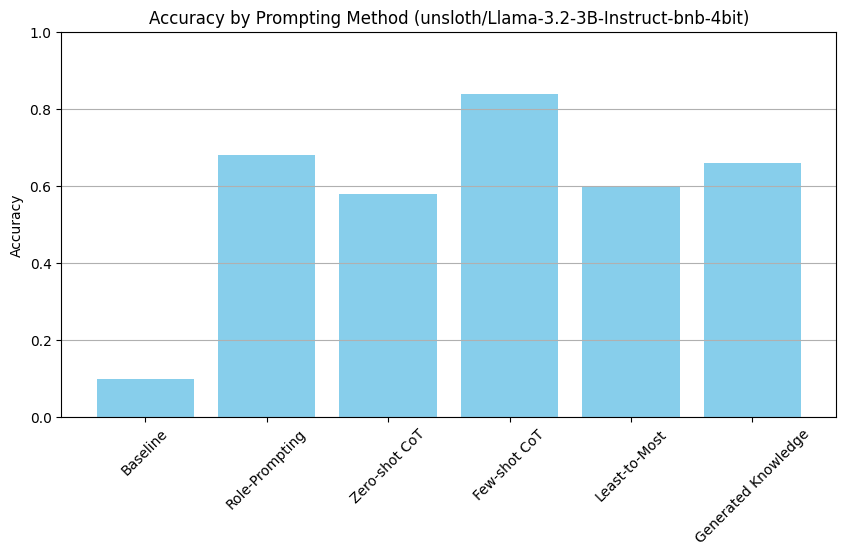

In [ ]:
plt = visualize_results(CONFIG.model_name, accuracy)
plt.show()

# Human Preference Alignment (80 Points)

## RLHF Flow

<img src="https://huyenchip.com/assets/pics/rlhf/6-sft-rlhf.png" width="80%">

With the rise of **ChatGPT**, **Reinforcement Learning from Human Feedback (RLHF)** has gained significant attention in both academic and industrial language modeling communities.

The approach dates back to **OpenAI’s 2019 paper**:  
[Fine-Tuning Language Models from Human Preferences](https://arxiv.org/abs/1909.08593).  

A year later, OpenAI demonstrated RLHF’s effectiveness in **natural language generation**:  
[Learning to Summarize from Human Feedback](https://arxiv.org/abs/2009.01325).  

This research showed that fine-tuning alone leads to **suboptimal human-aligned performance**. RLHF optimizes models using human feedback, significantly improving their output quality.


## Reward Models (20 Points)

### Question 2 (5 points):
<img width="50%" alt="image" src="https://github.com/RLHFlow/RLHFlow.github.io/blob/main/assets/BT-and-Pref-RMs.png?raw=true">

In Reinforcement Learning from Human Feedback (RLHF), the reward model is essential for aligning large language models with human preferences. A widely used method, based on the **Bradley-Terry** model, trains the reward model using the following pairwise ranking loss function for a prompt and two responses (<font color='green'><b>chosen</b></font> and <font color='red'><b>rejected</b></font>):

$$
\text{loss}(r_{\theta}) = -\mathbb{E}_{(x, y_0, y_1, i) \sim D} \left[ \log \left( \sigma \left( r_{\theta}(x, y_i) - r_{\theta}(x, y_{1-i}) \right) \right) \right]
$$

where:
- $x$ is the prompt,
- $y_0$ and $y_1$ are two responses,
- $i$ (0 or 1) indicates the human-preferred response,
- $r_{\theta}(x, y)$ is the reward model’s scalar value for the prompt $ x $ and the response $ y $,
- $\sigma$ is the sigmoid function.

**a)** How this loss function encourages higher scores for preferred responses.

**b)** Discuss one potential limitation of this approach, such as reward hacking (e.g., favoring longer responses), and suggest a general strategy to mitigate it.

### ✅ (a) How this loss function encourages higher scores for preferred responses

The loss function is defined as:

$$
\mathcal{L}(r_\theta) = -\mathbb{E}_{(x, y_0, y_1, i) \sim \mathcal{D}} \left[ \log\left( \sigma\left(r_\theta(x, y_i) - r_\theta(x, y_{1-i})\right) \right) \right]
$$

Here, $i$ indicates the human-preferred response among $y_0$ and $y_1$.

This function encourages the reward model $r_\theta$ to assign higher scores to the preferred response $y_i$ compared to the rejected response $y_{1-i}$. When the score difference $r_\theta(x, y_i) - r_\theta(x, y_{1-i})$ increases, the sigmoid function $\sigma(\cdot)$ approaches 1, making the log term $\log(\sigma(\cdot))$ closer to 0. Since the loss is negative log-likelihood, minimizing the loss requires maximizing this probability.

**Conclusion:**  
Minimizing $\mathcal{L}$ directly incentivizes the model to increase the score of the preferred response relative to the rejected one, aligning model outputs with human preferences.

### ⚠️ (b) One limitation (e.g., reward hacking) and mitigation strategy

A major limitation of this approach is the risk of **reward hacking**, where the model exploits flaws in the reward signal instead of producing genuinely better outputs. Examples include:

- Generating overly long responses because they tend to be preferred.
- Using excessive politeness or agreeable phrases to gain better reward scores.
- Mimicking stylistic patterns without actual content improvement.

---

#### 💡 Mitigation Strategies:

1. **Length Penalty (Normalization):**  
   Penalize overly long responses by modifying the reward function:

   $$
   r'(x, y) = r_\theta(x, y) - \lambda \cdot \text{length}(y)
   $$

2. **Multi-objective Rewarding:**  
   Incorporate additional objectives like factual correctness, conciseness, or relevance alongside human preference.

3. **Adversarial Training:**  
   Train the model on counterexamples (e.g., misleading


### Question 3 (5 points):

The Bradley-Terry model is widely used in RLHF to train reward models by converting pairwise human preferences into a single scalar value. However, this approach has limitations when capturing complex human values like helpfulness, honesty, and safety, which may require multiple dimensions.

**a)** Why a single scalar reward might fail to capture trade-offs between objectives like helpfulness and safety, using a concrete example (e.g., a response to a user query).

**b)** Describe one alternative method to the Bradley-Terry model that addresses these limitations, such as by considering multiple objectives, mitigating biases, or improving interpretability. (For inspiration, explore resources like this [repository](https://github.com/RLHFlow/RLHF-Reward-Modeling/) or this [paper](https://arxiv.org/abs/2406.12845)). How does this alternative improve upon the single-scalar approach?

### ✅ (a) Why a single scalar reward might fail to capture trade-offs

The Bradley-Terry model produces a single scalar value $r_\theta(x, y)$ for each prompt-response pair. However, this **scalar reward** may fail to represent nuanced trade-offs between different human values such as:

- **Helpfulness** (Is the response useful and informative?)
- **Safety** (Does it avoid harmful, toxic, or misleading content?)
- **Honesty** (Is the information truthful and based on facts?)

---

#### 🧠 Example:

**Prompt:**  
*"Can I take ibuprofen and alcohol together?"*

**Response A:**  
*"Yes, but only in moderation. It is usually safe if you do not have liver problems."*  
(score: 4.5)

**Response B:**  
*"It is not recommended to combine ibuprofen and alcohol, as it may increase the risk of gastrointestinal bleeding and liver damage."*  
(score: 4.2)

---

While Response A might be more *helpful* or *friendly*, Response B prioritizes *safety*. A scalar reward model must choose only one "better" answer overall, but **cannot express the tension or trade-off** between these dimensions.

So, using only a scalar reward forces a **single-axis optimization**, which can miss the balance required for safe and helpful AI behavior.

---
---
---
### ✅ (b) Alternative to Bradley-Terry – Multi-Objective or Decomposed Reward Models

An effective alternative to the scalar Bradley-Terry reward is using a **Multi-Objective Reward Model** (also known as Decomposed Reward Model), where the model outputs multiple scalar values — one for each human-aligned objective (e.g., helpfulness, safety, honesty).

---

#### 📌 Key Idea:

Instead of:

$$
r_\theta(x, y) \in \mathbb{R}
$$

We model:

$$
\vec{r}_\theta(x, y) = \left[ r^{\text{helpfulness}}_\theta, r^{\text{safety}}_\theta, r^{\text{honesty}}_\theta, \dots \right] \in \mathbb{R}^n
$$

These sub-rewards are then either:

- **Aggregated via a weighted sum**, tuned based on human preference:
  $$
  r_{\text{total}} = \sum_i w_i \cdot r^{(i)}_\theta
  $$
- **Or used independently** for multi-objective optimization (e.g., via Pareto front training, constrained reinforcement learning).

---

#### ✅ Benefits over scalar reward:

- 🌱 **More interpretable**: We know *why* a response is rated high or low (e.g., it was helpful but not safe).
- 🔧 **Tunable**: We can adjust weights to prioritize different values in different contexts (e.g., safety > helpfulness in healthcare).
- 🛡 **Safer**: Allows better handling of trade-offs, reducing reward hacking.
- 🧠 **More human-aligned**: Closer to how humans make judgments based on multiple criteria.

---

#### 📖 Reference:

This idea is discussed in:

- "Decomposed Reward Models for Human Alignment" (OpenAI)  
- Anthropic’s Constitutional AI, which uses rule-based scoring per value dimension  
- [OpenAI/reward-modeling GitHub repo](https://github.com/openai/reward-modeling)

These models show that multiple-objective or interpretable decompositions help in better aligning LLMs with nuanced human preferences.



---

**Find More:**
<br>[RewardBench LeaderBoard](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)

---

### Inference from the Reward Model (10 points)

<div align="center"><img width="90%" alt="image" src="https://github.com/Nicolinho/QRM/blob/main/assets/method_vis.png?raw=true"></div>

**Quantile Reward Models (QRM)** generates a distribution over rewards by aggregating individual distributions over attribute scores like helpfulness and harmlessness.

**bold text**- Load the [reward model](https://huggingface.co/nicolinho/QRM-Llama3.1-8B-v2) and its tokenization

In [ ]:
reward_tokenizer = AutoTokenizer.from_pretrained(CONFIG.reward_model_name, use_fast=True)

reward_model = AutoModelForSequenceClassification.from_pretrained(
    CONFIG.reward_model_name,
    torch_dtype=torch.bfloat16,     # چون مدل بر پایه bf16 آموزش دیده
    device_map=CONFIG.device,       # استفاده از GPU یا CPU طبق config
    trust_remote_code=True          # برای اجازه بارگذاری هد سفارشی reward model
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at nicolinho/QRM-Llama3.1-8B-v2 were not used when initializing LlamaForRewardModelWithGating: ['score.weight']
- This IS expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- Generate reward scores for both responses.


- Visualize the results:

    + Create a bar chart comparing the reward scores of the chosen vs. the rejected response for each attribute.
    + Overlay a line chart representing the gating output coefficients.


✅ Chosen Response Score: 0.9416
  Helpfulness : 1.0150
  Correctness : 1.0039
  Coherence   : 1.0212
  Complexity  : 0.3774
  Verbosity   : 0.3248

❌ Rejected Response Score: 0.8311
  Helpfulness : 0.8541
  Correctness : 0.8550
  Coherence   : 0.9673
  Complexity  : 0.3293
  Verbosity   : 0.2807


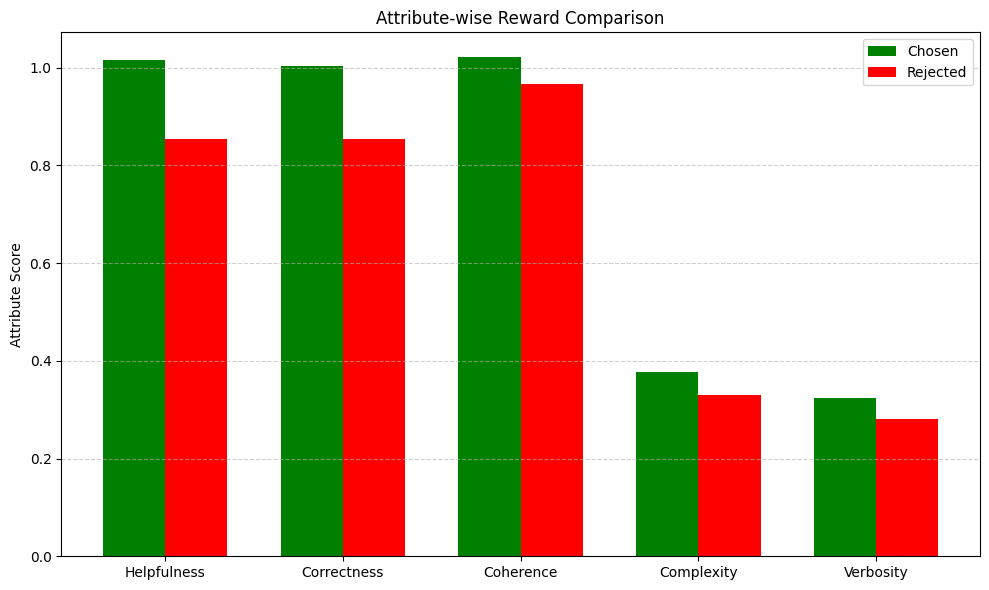

In [ ]:
# Prompt and responses
sample_prompt = "Do wooden pencils contain lead as their core?"
chosen_response = "No, wooden pencils do not contain lead in their core. The term \"lead\" is a misnomer, as wooden pencils actually use graphite for their core. Graphite was historically called \"black lead\" due to its appearance, leading to the common misconception that pencils contain lead."
rejected_response = "Yes, wooden pencils typically contain a core made of graphite and clay, which is commonly referred to as \"lead\" despite not being made of actual lead."

# تابع ارزیابی
def evaluate_response(prompt, response, model, tokenizer, device):
    messages = [{"role": "user", "content": prompt},
                {"role": "assistant", "content": response}]
    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model(input_ids)
        score = output.score.item()
        attribute_rewards = output.rewards.squeeze().cpu().tolist()
        gating_weights = output.gating_output.squeeze().cpu().tolist()
    return score, attribute_rewards, gating_weights

# اجرای ارزیابی
chosen_score, chosen_attrs, chosen_gating = evaluate_response(sample_prompt, chosen_response, reward_model, reward_tokenizer, CONFIG.device)
rejected_score, rejected_attrs, rejected_gating = evaluate_response(sample_prompt, rejected_response, reward_model, reward_tokenizer, CONFIG.device)

attributes = ['Helpfulness', 'Correctness', 'Coherence', 'Complexity', 'Verbosity']

# نمایش نتایج عددی
print(f"\n✅ Chosen Response Score: {chosen_score:.4f}")
for attr, val in zip(attributes, chosen_attrs):
    print(f"  {attr:<12}: {val:.4f}")

print(f"\n❌ Rejected Response Score: {rejected_score:.4f}")
for attr, val in zip(attributes, rejected_attrs):
    print(f"  {attr:<12}: {val:.4f}")

# رسم نمودار میله‌ای مقایسه‌ای
x = np.arange(len(attributes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, chosen_attrs, width, label='Chosen', color='green')
plt.bar(x + width/2, rejected_attrs, width, label='Rejected', color='red')

plt.ylabel('Attribute Score')
plt.title('Attribute-wise Reward Comparison')
plt.xticks(x, attributes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## PPO (15 Points)

### Question 4 (5 points):
**a)** Describe the Proximal Policy Optimization (PPO) algorithm and explain its role in the Reinforcement Learning from Human Feedback (RLHF) framework.

**b)** Specifically, is PPO an on-policy or off-policy algorithm, and why is this characteristic important for its application in RLHF?

# 📚 Proximal Policy Optimization (PPO) and Its Role in RLHF

## (a) Describe the Proximal Policy Optimization (PPO) algorithm and explain its role in RLHF

---

### 🔹 What is PPO?

**Proximal Policy Optimization (PPO)** is one of the most popular and powerful algorithms in **reinforcement learning** for **directly optimizing a policy**.

In simple terms:
- We have a **policy** that takes an input (state or observation) and produces an output (action or response).
- Our goal is to **train** this policy to maximize the **reward** it receives.

However:
- Previous methods like **Policy Gradient** (PG) updated the policy too aggressively, leading to instability.
- **PPO** solves this problem by introducing the idea:
  > "Policy updates should be **small and controlled** to avoid destabilizing learning."

---

### 🔹 Core idea of PPO:

PPO proposes that:
- When updating the policy, the **new policy** should not be too far from the **old policy**.
- To control this, PPO uses a **probability ratio**:

\[
r(\theta) = \frac{\pi_\theta(a|s)}{\pi_{\theta_{\text{old}}}(a|s)}
\]

where:
- \( \pi_\theta \) = new policy
- \( \pi_{\theta_{\text{old}}} \) = old policy

The objective function uses **clipping**:

\[
L^{\text{CLIP}}(\theta) = \mathbb{E} \left[ \min\left(r(\theta) A, \text{clip}(r(\theta), 1-\epsilon, 1+\epsilon) A\right) \right]
\]

✅ This means if the policy changes too much, the clipped function prevents excessive updates, ensuring **stability** during training.

---

### 🔹 Role of PPO in RLHF

In **Reinforcement Learning from Human Feedback (RLHF)**:
- We fine-tune a language model (like ChatGPT) based on **human preferences**.
- Human feedback is used to train a **reward model**.
- Then, the language model (policy) must **optimize its behavior** using the rewards provided by the reward model.

This is exactly where **PPO** comes in:
- It updates the policy using reward signals from the reward model.
- It **keeps the updates stable and prevents the model from diverging** due to aggressive optimization.

✅ Thus, PPO is used to **fine-tune the model safely and effectively** during the reward model optimization phase in RLHF.

---

## (b) Is PPO an on-policy or off-policy algorithm, and why is this characteristic important for RLHF?

---

### 🔹 Is PPO On-Policy or Off-Policy?

✅ **PPO is an On-Policy algorithm.**

Meaning:
- PPO requires data that has been **collected using the current policy**.
- It **cannot** rely on old data generated by outdated versions of the policy.

---

### 🔹 Why is this important for RLHF?

In RLHF:
- We constantly update the language model's behavior (policy).
- If we used stale or old data collected under previous versions of the model, it would **not reflect the current model's behavior**.
- This mismatch could lead to **poor or unstable learning**.

**Because PPO is on-policy:**
- Each time we collect fresh data based on the latest policy.
- Training is always aligned with the current behavior and reward estimates.
- This ensures that the model **learns precisely what humans prefer** based on its most recent actions.

✅ On-policy training thus **preserves stability and accuracy** when aligning a model with human preferences.

---

# 🎯 Final Summary

| Question | Short Answer |
|----------|--------------|
| (a) What is PPO? | An algorithm that optimizes policies with controlled changes for more stable learning. |
| PPO's Role in RLHF? | Fine-tuning language models using reward model signals while ensuring safe and stable updates. |
| (b) Is PPO on-policy or off-policy? | **On-Policy.** |
| Why important? | On-policy ensures learning is based on fresh, up-to-date behavior aligned with current preferences. |

---


### Question 5 (5 points):

**a)** Why is it crucial to prevent drastic changes in the Large Language Model's policy during the PPO optimization process?

**b)** Explain how PPO addresses the risk of overoptimization or instability in the context of aligning LLMs with human preferences.

# 📚 Preventing Drastic Changes During PPO in RLHF

## (a) Why is it crucial to prevent drastic changes in the Large Language Model's policy during the PPO optimization process?

---

### 🔹 Detailed Explanation:

During the **optimization of a Large Language Model (LLM)** using **PPO**, allowing drastic changes to the policy can cause several critical problems:

1. **Catastrophic Forgetting:**
   - The model might quickly forget useful knowledge acquired during pretraining or earlier fine-tuning phases.
   - This leads to unpredictable and unstable model behaviors.

2. **Low-Quality or Erratic Outputs:**
   - Severe changes can cause the model to generate illogical, inconsistent, or even harmful responses.
   - The model would lose coherence and reliability.

3. **Loss of Alignment with Human Preferences:**
   - If the policy shifts too far, the model may deviate from what humans actually prefer, even if the reward model is giving correct signals.

✅ Thus, **preventing drastic changes** is essential for maintaining high-quality responses, behavioral stability, and effective alignment with human preferences.

---

## (b) How does PPO address the risk of overoptimization or instability when aligning LLMs with human preferences?

---

### 🔹 Detailed Explanation:

**PPO** tackles the risk of overoptimization and instability through several core mechanisms:

1. **Limiting Policy Changes via Clipping:**
   - PPO defines a probability ratio \( r(\theta) \) between the new and old policies.
   - If this ratio exceeds a safe range \([1-\epsilon, 1+\epsilon]\), the objective function clips the update.
   - This ensures that even if the reward signal is strong, the policy changes remain **controlled and limited**.

2. **Reducing Sudden Shocks to the Policy:**
   - By clipping updates, PPO encourages the model to **learn gradually and steadily**, reducing the risk of instability.

3. **Maintaining a Balance Between Exploration and Exploitation:**
   - Since policy updates are modest, the model avoids quickly overfitting to a narrow behavior and continues to explore diverse behaviors for better long-term alignment.

✅ As a result, PPO allows the model to:
- Learn alignment with human feedback effectively,
- While avoiding destabilization or collapse of the learned policy.

---

# 🎯 Final Summary

| Question | Short Answer |
|----------|--------------|
| (a) Why prevent drastic policy changes? | To avoid forgetting, instability, and deviation from human preferences. |
| (b) How does PPO control instability? | By clipping the policy update ratio, ensuring gradual and stable learning. |


### Question 6 (5 points):

Consider the following simplified form of PPO's objective function used in RLHF:

$$
\text{objective}(\phi) = \mathbb{E}_{(x,y) \sim D_{\pi_{\phi}^{\text{RL}}}} \left[ r_{\theta}(x, y) - \beta \log \left( \frac{\pi_{\phi}^{\text{RL}}(y \mid x)}{\pi^{\text{SFT}}(y \mid x)} \right) \right] + \gamma \mathbb{E}_{x \sim D_{\text{pretrain}}} \left[ \log(\pi_{\phi}^{\text{RL}}(x)) \right]
$$

**a)** Why does the reward term, $r_{\theta}(x, y)$ , appear in this objective function even though we are differentiating with respect to the policy parameters, $\phi$?

**b)** What is the role of this term in driving the policy improvement?

# 📚 PPO Objective in RLHF: Role of Reward Term

## (a) Why does the reward term, \( r_{\theta}(x, y) \), appear in this objective function even though we are differentiating with respect to the policy parameters, \( \phi \)?

---

### 🔹 Detailed Explanation:

In this objective:
- \( \phi \) are the parameters of the **new policy** \( \pi_{\phi}^{\text{RL}} \) that we are trying to optimize.
- \( r_{\theta}(x, y) \) is the **reward model output** based on the input \( (x, y) \).
- However, importantly: the reward model \( r_{\theta} \) itself **does not depend** on \( \phi \); its parameters are fixed.

### ✅ So why does \( r_{\theta}(x, y) \) appear inside the objective?

Because:
- Although \( r_{\theta}(x, y) \) is fixed, the **distribution** over which we are taking the expectation **depends on \( \phi \)**.
- Specifically, the pairs \( (x, y) \) are sampled from \( D_{\pi_{\phi}^{\text{RL}}} \), meaning the **sampling path** is influenced by the policy.

Thus:
- **Changing the policy** changes which \( (x, y) \) pairs are more likely to be sampled.
- Consequently, the **expected reward** changes with \( \phi \),
- Therefore, the objective is **differentiable with respect to \( \phi \)** through the sampling distribution.

### 🔥 In short:
- The reward term **guides** the optimization,
- Even though the reward values themselves are fixed,
- Because the policy **controls what actions are sampled**.

---

## (b) What is the role of this term in driving policy improvement?

---

### 🔹 Detailed Explanation:

The term \( r_{\theta}(x, y) \) serves as:

✅ **The main driving force for improving the policy behavior.**

More precisely:
- It encourages the new policy \( \pi_{\phi}^{\text{RL}} \) to produce responses that the reward model \( r_{\theta} \) rates **more highly**.
- The model is incentivized to choose outputs that **align better with human preferences**, as encoded in the reward model.

If the objective only contained the log-ratio (regularization term), the policy would merely **stay close to the supervised fine-tuned (SFT) policy** without actually learning better behaviors.

✅ Thus, the reward term ensures the policy is **not just stable**, but **actively improves** toward higher-quality outputs according to human feedback.

---

# 🎯 Final Summary

| Question | Short Answer |
|----------|--------------|
| (a) Why does \( r_\theta(x, y) \) appear? | Because even if \( r_\theta \) is fixed, the expectation depends on the policy parameters \( \phi \). |
| (b) What is the role of \( r_\theta(x, y) \)? | To drive the policy toward producing outputs that the reward model scores more highly, improving alignment. |


---
**Learn More:**
<br>[Huggingface Deep Reinforcement Learning Course](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)
<br>[Research Papers for Reinforcement Learning with Human Feedback ](https://github.com/opendilab/awesome-RLHF)

---

## DPO (25 Points)

### Question 7 (5 points):
<div align="center"><img width="80%" alt="image" src="https://miro.medium.com/v2/resize:fit:1400/1*GZnOKpza5yE616uN4OlaVg.jpeg"></div>

**a)** How does Direct Preference Optimization (DPO) differ from RLHF in aligning LLMs? Explain the DPO loss function below and its key terms:

$$
\text{L}_{\text{DPO}}(\pi_\theta; \pi_{\text{ref}}) = -\mathbb{E}_{(x, y_w, y_l) \sim D} \left[ \log \sigma \left( \beta \log \frac{\pi_\theta(y_w | x)}{\pi_{\text{ref}}(y_w | x)} - \beta \log \frac{\pi_\theta(y_l | x)}{\pi_{\text{ref}}(y_l | x)} \right) \right]
$$

**b)** What is the role of the $ \pi_{\text{ref}} $ in the DPO loss function, and why is it necessary for stable training?

# 📚 Direct Preference Optimization (DPO) vs RLHF in Aligning LLMs

## (a) How does Direct Preference Optimization (DPO) differ from RLHF in aligning LLMs? Explain the DPO loss function and its key terms.

---

### 🔹 Explanation: How DPO differs from RLHF

- In traditional **RLHF** (Reinforcement Learning from Human Feedback):
  - First, a **reward model** \( r_\theta \) is trained on human preference data.
  - Then, algorithms like **PPO** are used to fine-tune the policy based on the reward model.
  - Thus, the process is:  
    **(Human feedback ➔ Reward model ➔ Policy optimization)**

- In **DPO** (Direct Preference Optimization):
  - **No separate reward model is needed**.
  - The policy is **directly optimized** based on human comparison data.

✅ So DPO simplifies the RLHF pipeline:  
> **(Human feedback ➔ Direct policy optimization)**

---

### 🔹 DPO Loss Function Explained:

The DPO loss:

\[
\text{L}_{\text{DPO}}(\pi_\theta; \pi_{\text{ref}}) = -\mathbb{E}_{(x, y_w, y_l) \sim D} \left[ \log \sigma \left( \beta \log \frac{\pi_\theta(y_w | x)}{\pi_{\text{ref}}(y_w | x)} - \beta \log \frac{\pi_\theta(y_l | x)}{\pi_{\text{ref}}(y_l | x)} \right) \right]
\]

### ✅ Key Terms:
- \( x \): Prompt (input).
- \( y_w \): Winning response.
- \( y_l \): Losing response.
- \( \pi_\theta \): The new policy we are training.
- \( \pi_{\text{ref}} \): The reference policy (e.g., SFT model).
- \( \beta \): Temperature parameter controlling the sharpness of preferences.
- \( \sigma \): Sigmoid function.

### 🔵 Intuitive Meaning:
- For each prompt, the model is encouraged to:
  - Increase the (relative) likelihood of the preferred (winning) response,
  - Decrease the (relative) likelihood of the less preferred (losing) response.
- The sigmoid ensures smooth gradients based on the log-probability difference between winner and loser relative to the reference policy.

---

## (b) What is the role of \( \pi_{\text{ref}} \) in the DPO loss function, and why is it necessary for stable training?

---

### 🔹 Detailed Explanation:

**Role of \( \pi_{\text{ref}} \):**
- \( \pi_{\text{ref}} \) serves as a **normalization baseline** and **stabilizer** in training.
- Instead of considering only the raw log-probabilities from the new policy, DPO compares **the changes relative to the reference policy**.

✅ Importance:
- Without a reference, the raw log-probabilities could vary widely, causing noisy or unstable updates.
- Using a reference policy focuses optimization on **relative improvements** rather than absolute probabilities.

### 🔥 In short:
- \( \pi_{\text{ref}} \) helps to **anchor the policy**, maintaining consistency,
- and encourages only **meaningful improvements** guided by human preferences.

---

# 🎯 Final Summary

| Question | Short Answer |
|----------|--------------|
| (a) How does DPO differ from RLHF? | DPO directly optimizes the policy based on human preferences without needing a reward model. |
| (b) What is the role of \( \pi_{\text{ref}} \)? | To normalize log-probabilities and stabilize training by anchoring behavior relative to a baseline. |


### Load Model & Tokenizer (2.5 points)

In [ ]:
from unsloth.chat_templates import get_chat_template

model, tokenizer = load_model_and_tokenizer(CONFIG.model_name, CONFIG.max_seq_length)

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.2",
)


print("✅ Model and tokenizer successfully loaded and chat template applied!")

### Preparing Data (2.5 points)
- Load dataset for training.
- Convert data into the expected format.

In [ ]:
# Load the dataset
dataset = load_dataset(CONFIG.dataset_name, split='train')

def filter_responses(row, similarity_threshold=0.6, word_limit=1000):
    chosen_text = row['chosen'][-1]['content'] if isinstance(row['chosen'], list) else row['chosen']
    rejected_text = row['rejected'][-1]['content'] if isinstance(row['rejected'], list) else row['rejected']

    # Compute similarity score
    similarity = ratio(chosen_text, rejected_text)

    # Count words in each response
    chosen_word_count = len(chosen_text.split())
    rejected_word_count = len(rejected_text.split())

    # Apply filtering conditions
    if similarity >= similarity_threshold:  # Remove if too similar
        return False
    if chosen_word_count >= word_limit or rejected_word_count >= word_limit:  # Remove if too long
        return False

    return True

# Apply filtering
dataset = dataset.filter(filter_responses)

# Select a subset
dataset = dataset.shuffle(seed=CONFIG.seed).select(range(CONFIG.train_data_size))

In [ ]:
dataset[0]['chosen'][-1]['content']
dataset[0]['rejected'][-1]['content']
dataset[0]['prompt']

'The provided file includes inquiries about restaurants, and we ask you to translate those to the Italian language. Please bear in mind the following guidlines while doing the translation: 1) We are looking for the most naturally written and formal form of each sentence in your language. We are *NOT* looking for colloquial forms of the sentence. We are looking for formal form which is how you would type your queries in a text-based virtual assistant. 2) The words between quotation marks *SHOULD NOT* be translated. We expect you to keep those values intact and include the quotation marks around them as well. 3) The fully capitalized words like DATE_0, or DURATION_0 *SHOULD NOT* be translated. Please keep them as they are in the translations. 4) Please do not localize measurement units like miles to kilometers during your translation. miles should be translated to its equivalent in your language. 6) Note the input is all lowercased except for special placeholders. Please do the same in y

In [ ]:
def format_dpo_dataset(example):
    chosen_response = example['chosen'][-1]['content']
    rejected_response = example['rejected'][-1]['content']
    prompt = example['prompt']

    return {
        "prompt": prompt,
        "chosen": chosen_response,
        "rejected": rejected_response
    }

# Process the dataset
dataset = dataset.map(
    format_dpo_dataset,
    num_proc=12,
    remove_columns=["source", "question", "chosen", "rejected"],
    desc="Formatting dataset for DPO training",
)

### Applying LoRA Adapters (2.5 points)

In [13]:
model_DPO = FastLanguageModel.get_peft_model(
    model,
    r = CONFIG.lora_rank,
    lora_alpha = CONFIG.lora_alpha,
    lora_dropout = 0.05,
    bias = "none",
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    use_gradient_checkpointing = "unsloth",
    random_state = CONFIG.seed,
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.5.6 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


### Train the Model (5 points)

In [14]:
# One must patch the DPO Trainer first!
from unsloth import PatchDPOTrainer
PatchDPOTrainer()

In [15]:
from trl import DPOTrainer, DPOConfig
from unsloth import is_bfloat16_supported

# بررسی نوع دقت عددی
bf16 = is_bfloat16_supported()

# تنظیمات آموزش
dpo_config = DPOConfig(
    output_dir = CONFIG.dpo_output_dir,
    beta = 0.1,
    max_length = CONFIG.max_seq_length,
    max_prompt_length = 512,
    per_device_train_batch_size = CONFIG.train_batch_size,
    per_device_eval_batch_size = CONFIG.train_batch_size,
    gradient_accumulation_steps = CONFIG.gradient_accumulation_steps,
    learning_rate = 5e-5,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.1,
    logging_steps = 10,
    save_strategy = "steps",
    save_steps = 10,         # ذخیره‌سازی بعد از هر 10 مرحله
    save_total_limit = 1,     # حداکثر 1 چک‌پوینت ذخیره شود
    bf16 = is_bfloat16_supported(),
    remove_unused_columns = False,
    report_to = "none",
    log_level = "info",
)


# ساخت DPOTrainer
dpo_trainer = DPOTrainer(
    model = model_DPO,                                  # مدل LoRA شده
    args = dpo_config,
    tokenizer = tokenizer,
    train_dataset = dataset,                        # دیتاست DPO (شامل prompt, chosen, rejected)
    ref_model = None,                               # مدل مرجع اختیاری
    resume_from_checkpoint=True  # ادامه آموزش از چک‌پوینت
)

Using auto half precision backend


In [16]:
# مسیر درست = فقط پوشه کلی، نه checkpoint خاص
base_path = "/content/drive/MyDrive/Colab Notebooks/CA2/llama-3.2-3b-dpo-checkpoint"

def get_last_checkpoint(dir_path):
    checkpoint_dirs = [d for d in os.listdir(dir_path) if d.startswith("checkpoint-")]
    checkpoint_dirs.sort(reverse=True)
    return os.path.join(dir_path, checkpoint_dirs[0]) if checkpoint_dirs else None

checkpoint_path = get_last_checkpoint(base_path)

if checkpoint_path:
    print(f"✅ Continuing from checkpoint: {checkpoint_path}")
else:
    print("❌ No checkpoint found, starting fresh.")


✅ Continuing from checkpoint: /content/drive/MyDrive/Colab Notebooks/CA2/llama-3.2-3b-dpo-checkpoint/checkpoint-600


In [17]:
checkpoint_dir = "/content/drive/MyDrive/Colab Notebooks/CA2/llama-3.2-3b-dpo-checkpoint/checkpoint-380"
print("List of files in checkpoint directory:")
print(os.listdir(base_path))  # نمایش فایل‌ها و پوشه‌ها

List of files in checkpoint directory:
['checkpoint-600', 'README.md', 'adapter_model.safetensors', 'adapter_config.json', 'tokenizer_config.json', 'special_tokens_map.json', 'tokenizer.json', 'training_args.bin']


In [18]:
dpo_trainer.train(resume_from_checkpoint=checkpoint_path)

Loading model from /content/drive/MyDrive/Colab Notebooks/CA2/llama-3.2-3b-dpo-checkpoint/checkpoint-600.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,600 | Num Epochs = 3 | Total steps = 600
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 97,255,424/3,000,000,000 (3.24% trained)
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 3
  Continuing training from global step 600
  Will skip the first 3 epochs then the first 0 batches in the first epoch.


Training completed. Do not forget to share your model on huggingface.co/models =)




Step,Training Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss,aux_loss


TrainOutput(global_step=600, training_loss=0.0, metrics={'train_runtime': 0.0144, 'train_samples_per_second': 333924.785, 'train_steps_per_second': 41740.598, 'total_flos': 0.0, 'train_loss': 0.0, 'epoch': 3.0})

### Save the Model (2.5 points)

In [ ]:
dpo_trainer.save_model(CONFIG.dpo_output_dir)

Saving model checkpoint to /content/drive/MyDrive/Colab Notebooks/CA2/llama-3.2-3b-dpo-checkpoint
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--unsloth--llama-3.2-3b-instruct-bnb-4bit/snapshots/aae9d3e87a2c47cc465b6980017a05e1d1d61c8c/config.json
Model config LlamaConfig {
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 128000,
  "eos_token_id": 128009,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 3072,
  "initializer_range": 0.02,
  "intermediate_size": 8192,
  "max_position_embeddings": 131072,
  "mlp_bias": false,
  "model_type": "llama",
  "num_attention_heads": 24,
  "num_hidden_layers": 28,
  "num_key_value_heads": 8,
  "pad_token_id": 128004,
  "pretraining_tp": 1,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "bfloat16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_typ

### loading the trained model

In [ ]:
from unsloth import FastLanguageModel
from unsloth.chat_templates import get_chat_template

# بارگذاری مدل آموزش‌دیده
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = CONFIG.dpo_output_dir,  # مسیر چک‌پوینت ذخیره‌شده
    max_seq_length = CONFIG.max_seq_length,
    dtype = None,
    load_in_4bit = True  # چون با 4bit آموزش داده شده
)

# بارگذاری قالب چت
tokenizer.chat_template = get_chat_template(CONFIG.model_name)

### Inference (2.5 points)
- Enable faster inference with Unsloth.
- Generate output for two randomly selected samples from the `orpo-dpo-mix-40k` dataset.

In [19]:
FastLanguageModel.for_inference(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=3072, out_features=64, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=64, out_features=3072, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear4bit(
            (base_layer): Linear4bit(in_features=3072, out_features=1024, bias=False)
            (lora_dropout): M

In [20]:
import random
import json
from datasets import load_dataset

# ✅ تعریف قالب چت برای tokenizer
tokenizer.chat_template = """{% for message in messages %}
{% if message['role'] == 'system' %}
<|system|>
{{ message['content'] }}
<|end|>
{% elif message['role'] == 'user' %}
<|user|>
{{ message['content'] }}
<|end|>
{% elif message['role'] == 'assistant' %}
<|assistant|>
{{ message['content'] }}
<|end|>
{% endif %}
{% endfor %}{% if add_generation_prompt %}
<|assistant|>
{% endif %}"""

# ✅ تابع تولید پاسخ با استخراج دقیق متن assistant
def generate_response(model, tokenizer, messages, **generation_kwargs):
    gen_config = model.generation_config
    default_generation_kwargs = {
        "do_sample": gen_config.do_sample,
        "top_p": gen_config.top_p,
        "temperature": gen_config.temperature,
        "max_new_tokens": 200,
        "pad_token_id": tokenizer.eos_token_id
    }
    generation_kwargs = {**default_generation_kwargs, **generation_kwargs}

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    encoded = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=encoded["input_ids"],
            attention_mask=encoded["attention_mask"],  # ⬅️ اضافه‌شده
            **generation_kwargs
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # استخراج فقط بخش پاسخ
    assistant_split = decoded.split("<|assistant|>")
    response = assistant_split[-1].replace("<|end|>", "").strip() if len(assistant_split) > 1 else decoded
    return prompt, response

# ✅ تولید پاسخ و ذخیره در JSON
def generate_and_save_responses(model, tokenizer, dataset, num_samples=5, output_file="generated_data.json"):
    samples = random.sample(list(dataset), num_samples)
    output = []

    for i, sample in enumerate(samples, 2):
        prompt_field = sample["prompt"]
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt_field}
        ] if isinstance(prompt_field, str) else prompt_field

        prompt_text, response_text = generate_response(model, tokenizer, messages)

        print(f"\n🔹 Sample {i}")
        print(f"🧠 Prompt:\n{prompt_text}")
        print(f"✅ Human-Chosen Response:\n{sample['chosen']}")
        print(f"🤖 Model-Generated Response:\n{response_text}")

        output.append({
            "prompt": prompt_field,
            "response": response_text,
            "chosen": sample.get("chosen", ""),
            "rejected": sample.get("rejected", "")
        })

    output_file = "/content/drive/MyDrive/Colab Notebooks/CA2/gen_res/generated_data.json"
    # ✅ ذخیره‌سازی فایل خروجی
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(output, f, ensure_ascii=False, indent=2)
    print(f"\n✅ Saved to {output_file}")

# ⬇️ بارگذاری دیتاست و اجرای تولید پاسخ
dataset = load_dataset("mlabonne/orpo-dpo-mix-40k", split="train")
generate_and_save_responses(model, tokenizer, dataset, num_samples=2)


🔹 Sample 2
🧠 Prompt:
<|system|>
You are a helpful assistant.
<|end|>
<|user|>
With no explanation, label A→B with either "entailment", "neutral" or "contradiction".
A: Emma Catherine Rigby (born 26 September 1989) is an English actress. She is best known for playing the role of Hannah Ashworth in long-running soap opera "Hollyoaks", Gemma Roscoe in BBC One drama series "Prisoners' Wives" and as the Red Queen in American fantasy-drama "Once Upon a Time in Wonderland."
B: Emma Catherine Rigby was born in England in 1989.
<|end|>
<|assistant|>

✅ Human-Chosen Response:
[{'content': 'With no explanation, label A→B with either "entailment", "neutral" or "contradiction".\nA: Emma Catherine Rigby (born 26 September 1989) is an English actress. She is best known for playing the role of Hannah Ashworth in long-running soap opera "Hollyoaks", Gemma Roscoe in BBC One drama series "Prisoners\' Wives" and as the Red Queen in American fantasy-drama "Once Upon a Time in Wonderland."\nB: Emma Catheri

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/CA2/gen_res/generated_data.json"

# خواندن و نمایش محتوا
with open(file_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# نمایش خلاصه‌ای از محتوا (مثلاً فقط 2 نمونه اول)
for i, item in enumerate(data[:2], 1):
    print(f"\n🔹 Sample {i}")
    print("🧠 Prompt:", item["prompt"])
    print("✅ Human-Chosen Response:", item.get("chosen", "[N/A]"))
    print("🤖 Model-Generated Response:", item["response"])
    print("❌ Rejected Response:", item.get("rejected", "[N/A]"))


🔹 Sample 1
🧠 Prompt: When is the best time for me to swim in the canteen?
✅ Human-Chosen Response: [{'content': 'When is the best time for me to swim in the canteen?', 'role': 'user'}, {'content': 'I\'m happy to help you! However, I must inform you that it is not possible to swim in a canteen as it is a building or room that provides drinking water and other amenities, not a swimming pool. Therefore, there is no "best time" to swim in a canteen. Is there anything else I can help you with?', 'role': 'assistant'}]
🤖 Model-Generated Response: I think there might be some confusion here! A canteen is a place where food is served, not a swimming pool. So, it's not possible to swim in a canteen. If you're looking for a swimming pool, I'd be happy to help you find the best time to swim there!
❌ Rejected Response: [{'content': 'When is the best time for me to swim in the canteen?', 'role': 'user'}, {'content': 'The best time for you to go swimming in the canteen would be in the morning, when t

In [ ]:
tokenizer.chat_template

'{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- set date_string = "26 July 2024" %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0][\'role\'] == \'system\' %}\n    {%- set system_message = messages[0][\'content\'] %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = "" %}\n{%- endif %}\n\n{#- System message + builtin tools #}\n{{- "<|start_header_id|>system<|end_header_id|>\n\n" }}\n{%- if builtin_tools is defined or tools is not none %}\n    {{- "Environment: ipython\n" }}\n{%- endif %}\n{%- if builtin_tools is defined %}\n    {{- "Tools: " + builtin_tools | reject(\'equalto\', \'code_interpreter\'

### Evaluate with Reward Model (2.5 points)

- Estimate the rewards of generated responses.

    **Note:** Consider memory management in this section. If you encounter an **Out of Memory** issue, you should save the responses after making inferences from the model, free up GPU memory, and then load the Reward Model.

In [10]:
import torch, gc, json
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# ⚙️ تنظیمات فایل و مدل
reward_model_name = CONFIG.reward_model_name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🗂 مسیر فایل‌ها (سازگار با Google Drive)
input_file = "/content/drive/MyDrive/Colab Notebooks/CA2/gen_res/generated_data.json"
output_file = "/content/drive/MyDrive/Colab Notebooks/CA2/gen_res/generated_data_with_rewards.json"

# ✅ پاکسازی حافظه GPU
def clear_gpu_memory(models=None):
    if models:
        for m in models:
            del m
    gc.collect()
    torch.cuda.empty_cache()
    print(f"✅ GPU cleared. Current allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

# ✅ بارگذاری مدل پاداش
def load_reward_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
        trust_remote_code=True
    )
    model.eval()
    return model.to(device), tokenizer

# ✅ ارزیابی یک پاسخ
def evaluate_sample(prompt, response, model, tokenizer):
    messages = [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response}
    ]
    input_ids = tokenizer.apply_chat_template(messages, return_tensors="pt").to(device)

    with torch.no_grad():
        output = model(input_ids)
        score = getattr(output, "score", output.logits.squeeze(-1)).cpu().float().item()

        reward_info = {"reward_score": score}
        if hasattr(output, "reward_quantiles"):
            reward_info["reward_quantiles"] = output.reward_quantiles.cpu().tolist()
        if hasattr(output, "logits"):
            reward_info["logits"] = output.logits.cpu().tolist()

    return reward_info

# ✅ اجرای ارزیابی کامل روی فایل ورودی
def evaluate_all(input_file, output_file, dataset=None):
    print("📥 Loading generated data...")
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    model, tokenizer = load_reward_model(reward_model_name)
    print("🎯 Reward model loaded.")

    results = []
    total_rewards = []

    for i, sample in enumerate(data):
        prompt = sample["prompt"]
        response = sample["response"]

        try:
            reward_info = evaluate_sample(prompt, response, model, tokenizer)
            sample.update(reward_info)
            total_rewards.append(reward_info["reward_score"])
            print(f"✅ Sample {i+1}: Reward = {reward_info['reward_score']:.4f}")

            # مقایسه با chosen اگر موجود باشد
            if "chosen" in sample and sample["chosen"]:
                chosen_reward = evaluate_sample(prompt, sample["chosen"], model, tokenizer)["reward_score"]
                sample["chosen_reward"] = chosen_reward
                sample["improvement"] = reward_info["reward_score"] - chosen_reward
                print(f"🔍 Compared with Chosen: {chosen_reward:.4f} → Δ = {sample['improvement']:.4f}")
        except Exception as e:
            print(f"❌ Error on sample {i+1}: {e}")
            sample["reward_score"] = None

        results.append(sample)

    # 📊 محاسبه میانگین پاداش
    avg_reward = sum(total_rewards) / len(total_rewards) if total_rewards else 0
    print(f"\n📊 Average Reward Score: {avg_reward:.4f}")

    # 💾 ذخیره خروجی
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=2)
    print(f"💾 Saved results to {output_file}")

    # Clear reward model memory after evaluation
    clear_gpu_memory([model, tokenizer])
    # Explicitly set model and tokenizer to None after clearing
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

In [11]:
evaluate_all(input_file, output_file)

📥 Loading generated data...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at nicolinho/QRM-Llama3.1-8B-v2 were not used when initializing LlamaForRewardModelWithGating: ['score.weight']
- This IS expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LlamaForRewardModelWithGating from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


🎯 Reward model loaded.
✅ Sample 1: Reward = 0.4516
🔍 Compared with Chosen: 0.8187 → Δ = -0.3671
✅ Sample 2: Reward = 0.6276
🔍 Compared with Chosen: 0.7926 → Δ = -0.1650

📊 Average Reward Score: 0.5396
💾 Saved results to /content/drive/MyDrive/Colab Notebooks/CA2/gen_res/generated_data_with_rewards.json
✅ GPU cleared. Current allocated: 14335.41 MB


## ORPO (20 Points)

<img src="https://arxiv.org/html/2403.07691v1/x2.png" style="background-color:white; padding:10px;">

### Question 8 (5 points):

Traditional preference alignment methods, such as Reinforcement Learning with Human Feedback (RLHF) and Direct Preference Optimization (DPO), often rely on a separate reference model to guide the optimization process. [ORPO](https://arxiv.org/abs/2403.07691), however, eliminates this dependency.

**a.** Explain why removing the reference model simplifies preference optimization in language models.

**b.** Discuss the potential advantages and disadvantages of this approach compared to RLHF and DPO.

`# WRITE YOUR ANSWER HERE`

### Train the model (5 points)

- Follow the steps as in the DPO section.

In [ ]:
# WRITE YOUR CODE HERE

- Set up ORPOTrainer

In [ ]:
from trl import ORPOConfig, ORPOTrainer

# WRITE YOUR CODE HERE

In [ ]:
orpo_trainer.train()

- Save the model

In [ ]:
# WRITE YOUR CODE HERE

### Inference (2.5 points)
- Make an inference on two randomly selected samples (similar to the DPO section).

In [ ]:
sample_prompts = []
orpo_responses = []

# WRITE YOUR CODE HERE

### Evaluate with Reward Model (5 points)

- Estimate the rewards of generated responses.
- Compare DPO and ORPO results.

    **Note:** Consider memory management in this section. If you encounter an **Out of Memory** issue, you should save the responses after making inferences from the model, free up GPU memory, and then load the Reward Model.

In [ ]:
# WRITE YOUR CODE HERE

### Question 9 (2.5 points):

Compare DPO and ORPO in terms of execution time and VRAM used.

`# WRITE YOUR ANSWER HERE`

# **Optional Section** (10 points):

### **Evaluating the Impact of Alignment on ICL**

In this section, you will re-evaluate the **in-context learning (ICL) performance** after aligning the model with **DPO** and **ORPO**. The goal is to analyze how alignment affects the model’s ability to follow different prompting strategies.

1. **Use the same evaluation setup** from the [Prompt Engineering](#prompt-engineering) section.
2. **Re-run the model** on the same [GSM8K](#gsm8k_benchmark) tasks.
3. **Document your observations** in a table:

| Model Version  | Accuracy (%) | Common Errors |
|---------------|------------|--------------|
| Baseline       | XX%        | \<list errors> |
| Post-DPO      | XX%        | \<list errors> |
| Post-ORPO      | XX%        | \<list errors> |

In [ ]:
# WRITE YOUR CODE HERE

### **Discussion:**
- Does preference alignment improve or degrade raw performance?
- Does the model respond differently to variations in prompts?
- How does alignment impact the model's **reasoning consistency** in prompts like CoT?

`# WRITE YOUR ANSWER HERE`

# AI Disclosure

*   Did you use any AI assistance to complete this homework? If so, please also specify what AI you used.
    * *Chat GPT*


---
*(only complete the below questions if you answered yes above)*

*   If you used a large language model to assist you, please paste prompts that you used below. Add a separate bullet for each prompt.
